# AutoEncoders

## Example 1: Basic Autoencoder for Dimensionality Reduction

Trains a simple autoencoder to compress MNIST handwritten digit images into a 32-dimensional latent space and then reconstruct them, visualizing both the reconstructed images and the encoded representations.
Exercises for Students:

- Exercise 1: Modify the latent space size (try 2, 8, and 64) and observe how it affects reconstruction quality
- Exercise 2: Use the trained encoder component to extract features for a digit classification task


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.99MB/s]


Epoch [1/10], Batch [100/469], Loss: 0.0633
Epoch [1/10], Batch [200/469], Loss: 0.0486
Epoch [1/10], Batch [300/469], Loss: 0.0372
Epoch [1/10], Batch [400/469], Loss: 0.0338
Epoch [1/10], Average Loss: 0.0517
Epoch [2/10], Batch [100/469], Loss: 0.0260
Epoch [2/10], Batch [200/469], Loss: 0.0261
Epoch [2/10], Batch [300/469], Loss: 0.0212
Epoch [2/10], Batch [400/469], Loss: 0.0209
Epoch [2/10], Average Loss: 0.0243
Epoch [3/10], Batch [100/469], Loss: 0.0198
Epoch [3/10], Batch [200/469], Loss: 0.0176
Epoch [3/10], Batch [300/469], Loss: 0.0175
Epoch [3/10], Batch [400/469], Loss: 0.0182
Epoch [3/10], Average Loss: 0.0191
Epoch [4/10], Batch [100/469], Loss: 0.0182
Epoch [4/10], Batch [200/469], Loss: 0.0174
Epoch [4/10], Batch [300/469], Loss: 0.0153
Epoch [4/10], Batch [400/469], Loss: 0.0150
Epoch [4/10], Average Loss: 0.0169
Epoch [5/10], Batch [100/469], Loss: 0.0154
Epoch [5/10], Batch [200/469], Loss: 0.0164
Epoch [5/10], Batch [300/469], Loss: 0.0149
Epoch [5/10], Batch [400

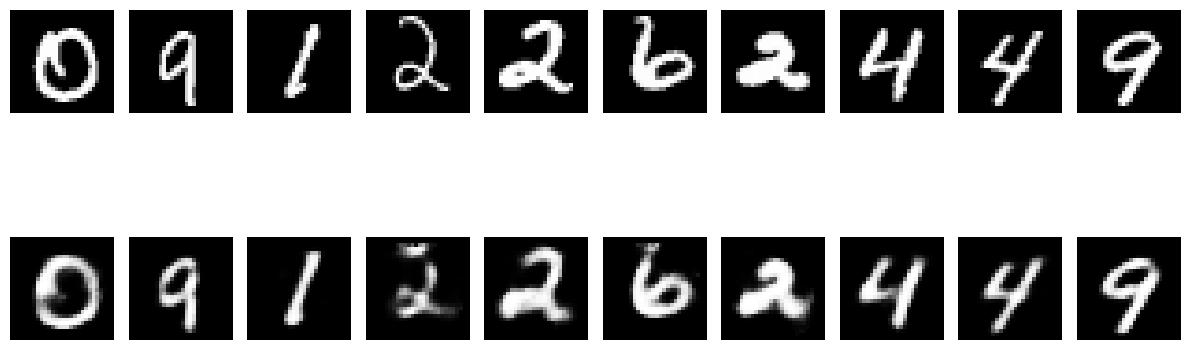

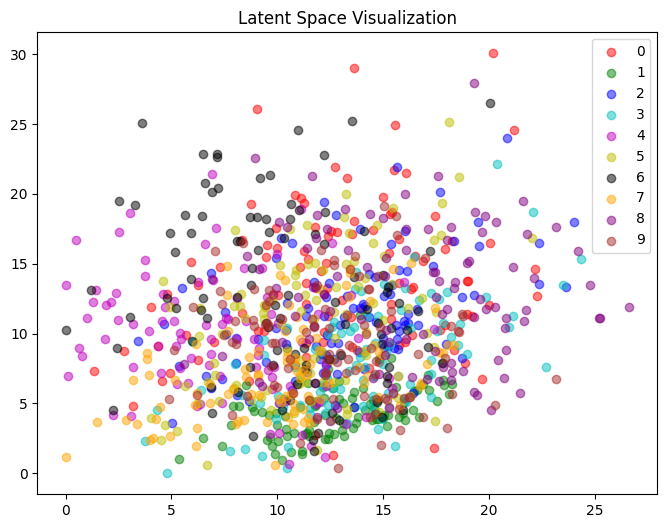

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 128
latent_size = 32  # Compressed representation size
batch_size = 128
num_epochs = 10
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Initialize model
model = Autoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
def train():
    total_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            reconstructed, encoded = model(data)
            loss = criterion(reconstructed, data.view(-1, input_size))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Print average loss after each epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
        total_loss = 0

# Run training
train()

# Visualization
def visualize_reconstruction():
    model.eval()
    with torch.no_grad():
        # Get sample data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        # Reconstruct images
        reconstructed, encoded = model(data)
        
        # Plot original and reconstructed images
        plt.figure(figsize=(12, 6))
        for i in range(10):
            # Original
            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            
            # Reconstructed
            ax = plt.subplot(2, 10, i + 11)
            plt.imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize the latent space
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
        for i in range(10):
            idx = (test_dataset.targets == i)
            x_data = test_dataset.data[idx][:100].float() / 255.0
            x_data = x_data.view(-1, input_size).to(device)
            _, encoded_data = model(x_data)
            plt.scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), color=colors[i], label=str(i), alpha=0.5)
        
        plt.legend()
        plt.title("Latent Space Visualization")
        plt.show()

# Visualize reconstructions and latent space
visualize_reconstruction()

# Save the model
torch.save(model.state_dict(), 'autoencoder.pth')

## Example 2: Denoising Autoencoder

What this code does: Trains a denoising autoencoder that learns to recover clean MNIST digit images from artificially corrupted versions with random noise, visualizing the original, noisy, and reconstructed images.
Exercises for Students:

- Exercise 1: Experiment with different noise factors (0.1, 0.5, 0.8) and observe the model's ability to denoise images
- Exercise 2: Implement a convolutional denoising autoencoder to improve reconstruction quality
- Exercise 3: can you do it for the CIFAR dataset?
    - https://github.com/mmaleki92/Denoising-Autoencoder-cifar-10 

Epoch [1/15], Batch [100/469], Loss: 0.0636
Epoch [1/15], Batch [200/469], Loss: 0.0425
Epoch [1/15], Batch [300/469], Loss: 0.0350
Epoch [1/15], Batch [400/469], Loss: 0.0291
Epoch [1/15], Average Loss: 0.0480
Epoch [2/15], Batch [100/469], Loss: 0.0263
Epoch [2/15], Batch [200/469], Loss: 0.0246
Epoch [2/15], Batch [300/469], Loss: 0.0222
Epoch [2/15], Batch [400/469], Loss: 0.0211
Epoch [2/15], Average Loss: 0.0237
Epoch [3/15], Batch [100/469], Loss: 0.0209
Epoch [3/15], Batch [200/469], Loss: 0.0196
Epoch [3/15], Batch [300/469], Loss: 0.0181
Epoch [3/15], Batch [400/469], Loss: 0.0181
Epoch [3/15], Average Loss: 0.0187
Epoch [4/15], Batch [100/469], Loss: 0.0160
Epoch [4/15], Batch [200/469], Loss: 0.0167
Epoch [4/15], Batch [300/469], Loss: 0.0160
Epoch [4/15], Batch [400/469], Loss: 0.0157
Epoch [4/15], Average Loss: 0.0162
Epoch [5/15], Batch [100/469], Loss: 0.0153
Epoch [5/15], Batch [200/469], Loss: 0.0152
Epoch [5/15], Batch [300/469], Loss: 0.0144
Epoch [5/15], Batch [400

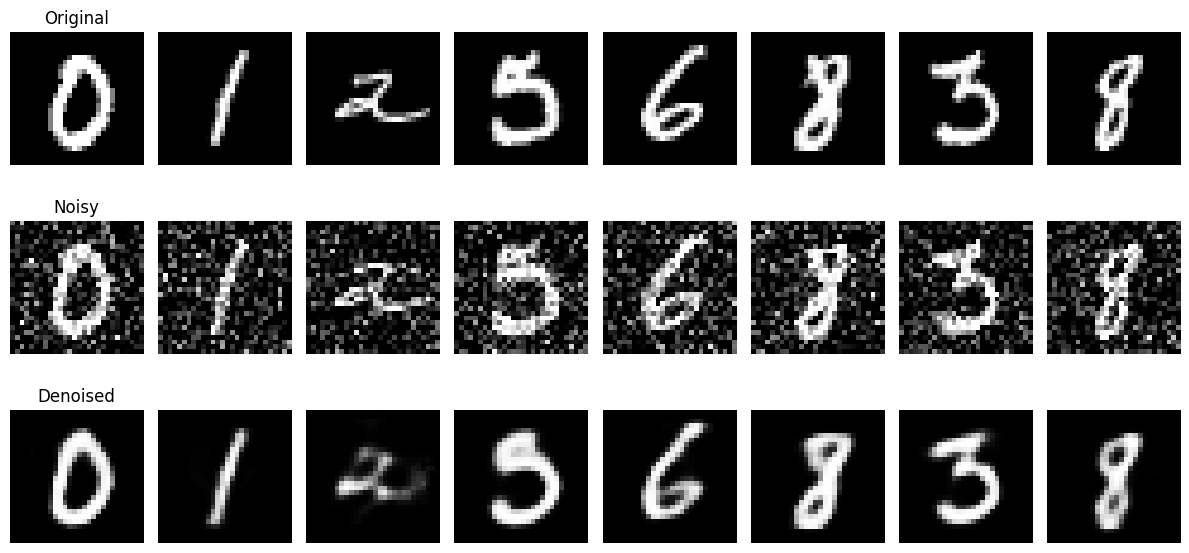

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 256
latent_size = 64
batch_size = 128
num_epochs = 15
learning_rate = 0.001
noise_factor = 0.3  # Amount of noise to add

# MNIST Dataset with noise addition
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Denoising Autoencoder Model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, input_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
model = DenoisingAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Add noise to images
def add_noise(images, noise_factor):
    noisy_images = images + noise_factor * torch.randn_like(images)
    # Clip the images to be between 0 and 1
    return torch.clamp(noisy_images, 0., 1.)

# Training
def train():
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Add noise to the input images
            noisy_data = add_noise(data, noise_factor).to(device)
            
            # Forward pass
            reconstructed = model(noisy_data)
            
            # Calculate loss (compare to clean data)
            loss = criterion(reconstructed, data.view(-1, input_size))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Print average loss after each epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Run training
train()

# Visualization
def visualize_denoising():
    model.eval()
    with torch.no_grad():
        # Get sample data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)
        data, _ = next(iter(test_loader))
        
        # Create noisy images
        noisy_data = add_noise(data, noise_factor)
        
        # Reconstruct images
        noisy_data = noisy_data.to(device)
        reconstructed = model(noisy_data)
        
        # Plot original, noisy and reconstructed images
        plt.figure(figsize=(12, 6))
        for i in range(8):
            # Original
            ax = plt.subplot(3, 8, i + 1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                ax.set_title("Original")
            
            # Noisy
            ax = plt.subplot(3, 8, i + 9)
            plt.imshow(noisy_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                ax.set_title("Noisy")
            
            # Reconstructed
            ax = plt.subplot(3, 8, i + 17)
            plt.imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                ax.set_title("Denoised")
        
        plt.tight_layout()
        plt.show()

# Visualize denoising results
visualize_denoising()

# Save the model
torch.save(model.state_dict(), 'denoising_autoencoder.pth')

## Example 3: Autoencoder for Anomaly Detection

Epoch [1/15], Average Loss: 0.0930
Epoch [2/15], Average Loss: 0.0484
Epoch [3/15], Average Loss: 0.0381
Epoch [4/15], Average Loss: 0.0309
Epoch [5/15], Average Loss: 0.0267
Epoch [6/15], Average Loss: 0.0239
Epoch [7/15], Average Loss: 0.0213
Epoch [8/15], Average Loss: 0.0192
Epoch [9/15], Average Loss: 0.0174
Epoch [10/15], Average Loss: 0.0162
Epoch [11/15], Average Loss: 0.0153
Epoch [12/15], Average Loss: 0.0146
Epoch [13/15], Average Loss: 0.0139
Epoch [14/15], Average Loss: 0.0132
Epoch [15/15], Average Loss: 0.0127


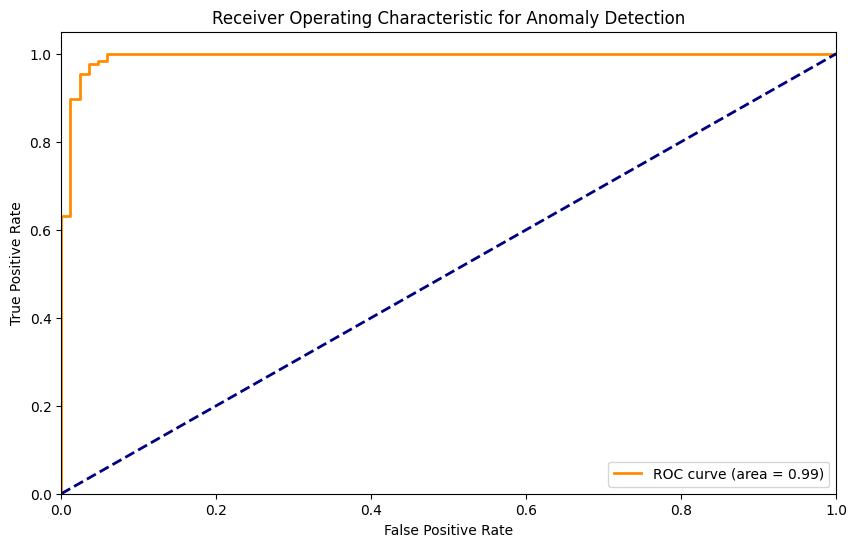

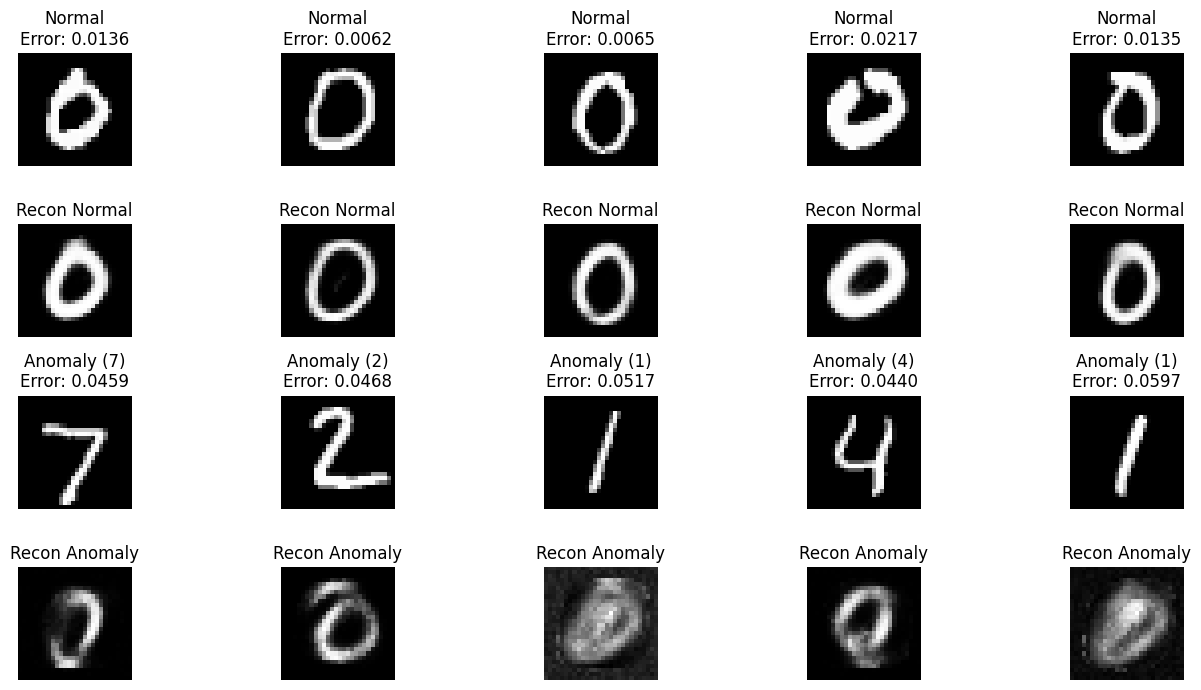

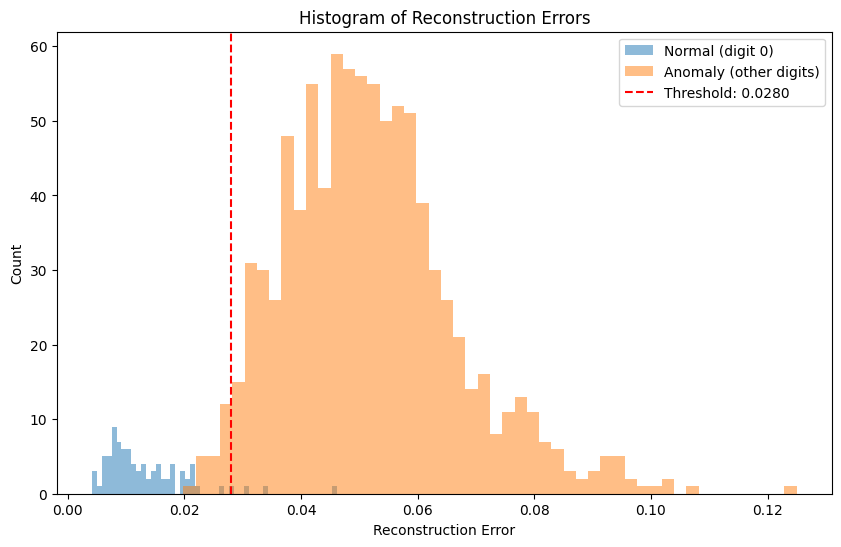

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 256
latent_size = 64
batch_size = 128
num_epochs = 15
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# We'll use only digit 0 as the normal class for training
# Everything else will be considered an anomaly
normal_idx = torch.where(mnist_dataset.targets == 0)[0]
train_dataset = Subset(mnist_dataset, normal_idx)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# For testing, we'll use a mix of normal (digit 0) and anomalous data (other digits)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Anomaly Detection Autoencoder
class AnomalyAutoencoder(nn.Module):
    def __init__(self):
        super(AnomalyAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, input_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
model = AnomalyAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
def train():
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            reconstructed = model(data)
            
            # Calculate loss
            loss = criterion(reconstructed, data.view(-1, input_size)).mean()
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Print average loss after each epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Run training
train()

# Evaluate for anomaly detection
def evaluate_anomaly_detection():
    model.eval()
    with torch.no_grad():
        # Get test data
        test_data, test_labels = next(iter(test_loader))
        test_data = test_data.to(device)
        
        # Get reconstructed data
        reconstructed = model(test_data)
        
        # Calculate reconstruction error for each sample
        reconstruction_error = criterion(reconstructed, test_data.view(-1, input_size)).mean(dim=1).cpu().numpy()
        
        # Create binary labels (0 is normal, everything else is anomaly)
        anomaly_labels = (test_labels != 0).cpu().numpy().astype(int)
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(anomaly_labels, reconstruction_error)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for Anomaly Detection')
        plt.legend(loc="lower right")
        plt.show()
        
        # Find optimal threshold using Youden's J statistic
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Plot examples of normal and anomalous data with their reconstruction
        plt.figure(figsize=(14, 7))
        
        # Get some normal data (digit 0)
        normal_idx = torch.where(test_labels == 0)[0][:5]
        normal_data = test_data[normal_idx]
        normal_recon = model(normal_data)
        normal_error = criterion(normal_recon, normal_data.view(-1, input_size)).mean(dim=1).cpu().numpy()
        
        # Get some anomaly data (not digit 0)
        anomaly_idx = torch.where(test_labels != 0)[0][:5]
        anomaly_data = test_data[anomaly_idx]
        anomaly_recon = model(anomaly_data)
        anomaly_error = criterion(anomaly_recon, anomaly_data.view(-1, input_size)).mean(dim=1).cpu().numpy()
        
        # Plot normal data
        for i in range(5):
            # Original normal
            plt.subplot(4, 5, i + 1)
            plt.imshow(normal_data[i].cpu().reshape(28, 28), cmap='gray')
            plt.title(f"Normal\nError: {normal_error[i]:.4f}")
            plt.axis('off')
            
            # Reconstructed normal
            plt.subplot(4, 5, i + 6)
            plt.imshow(normal_recon[i].cpu().reshape(28, 28), cmap='gray')
            plt.title(f"Recon Normal")
            plt.axis('off')
            
            # Original anomaly
            plt.subplot(4, 5, i + 11)
            plt.imshow(anomaly_data[i].cpu().reshape(28, 28), cmap='gray')
            plt.title(f"Anomaly ({test_labels[anomaly_idx[i]]})\nError: {anomaly_error[i]:.4f}")
            plt.axis('off')
            
            # Reconstructed anomaly
            plt.subplot(4, 5, i + 16)
            plt.imshow(anomaly_recon[i].cpu().reshape(28, 28), cmap='gray')
            plt.title(f"Recon Anomaly")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Plot histogram of reconstruction errors
        plt.figure(figsize=(10, 6))
        plt.hist(reconstruction_error[anomaly_labels == 0], bins=50, alpha=0.5, label='Normal (digit 0)')
        plt.hist(reconstruction_error[anomaly_labels == 1], bins=50, alpha=0.5, label='Anomaly (other digits)')
        plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.4f}')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count')
        plt.title('Histogram of Reconstruction Errors')
        plt.legend()
        plt.show()

# Evaluate the model for anomaly detection
evaluate_anomaly_detection()

# Save the model
torch.save(model.state_dict(), 'anomaly_autoencoder.pth')

## Example 4: Autoencoder for PCA-like Dimensionality Reduction

Epoch [1/15], Batch [100/469], Loss: 0.1119
Epoch [1/15], Batch [200/469], Loss: 0.0949
Epoch [1/15], Batch [300/469], Loss: 0.0820
Epoch [1/15], Batch [400/469], Loss: 0.0671
Epoch [1/15], Average Loss: 0.0909
Epoch [2/15], Batch [100/469], Loss: 0.0632
Epoch [2/15], Batch [200/469], Loss: 0.0620
Epoch [2/15], Batch [300/469], Loss: 0.0640
Epoch [2/15], Batch [400/469], Loss: 0.0634
Epoch [2/15], Average Loss: 0.0636
Epoch [3/15], Batch [100/469], Loss: 0.0607
Epoch [3/15], Batch [200/469], Loss: 0.0653
Epoch [3/15], Batch [300/469], Loss: 0.0657
Epoch [3/15], Batch [400/469], Loss: 0.0627
Epoch [3/15], Average Loss: 0.0629
Epoch [4/15], Batch [100/469], Loss: 0.0621
Epoch [4/15], Batch [200/469], Loss: 0.0614
Epoch [4/15], Batch [300/469], Loss: 0.0591
Epoch [4/15], Batch [400/469], Loss: 0.0620
Epoch [4/15], Average Loss: 0.0612
Epoch [5/15], Batch [100/469], Loss: 0.0605
Epoch [5/15], Batch [200/469], Loss: 0.0584
Epoch [5/15], Batch [300/469], Loss: 0.0592
Epoch [5/15], Batch [400

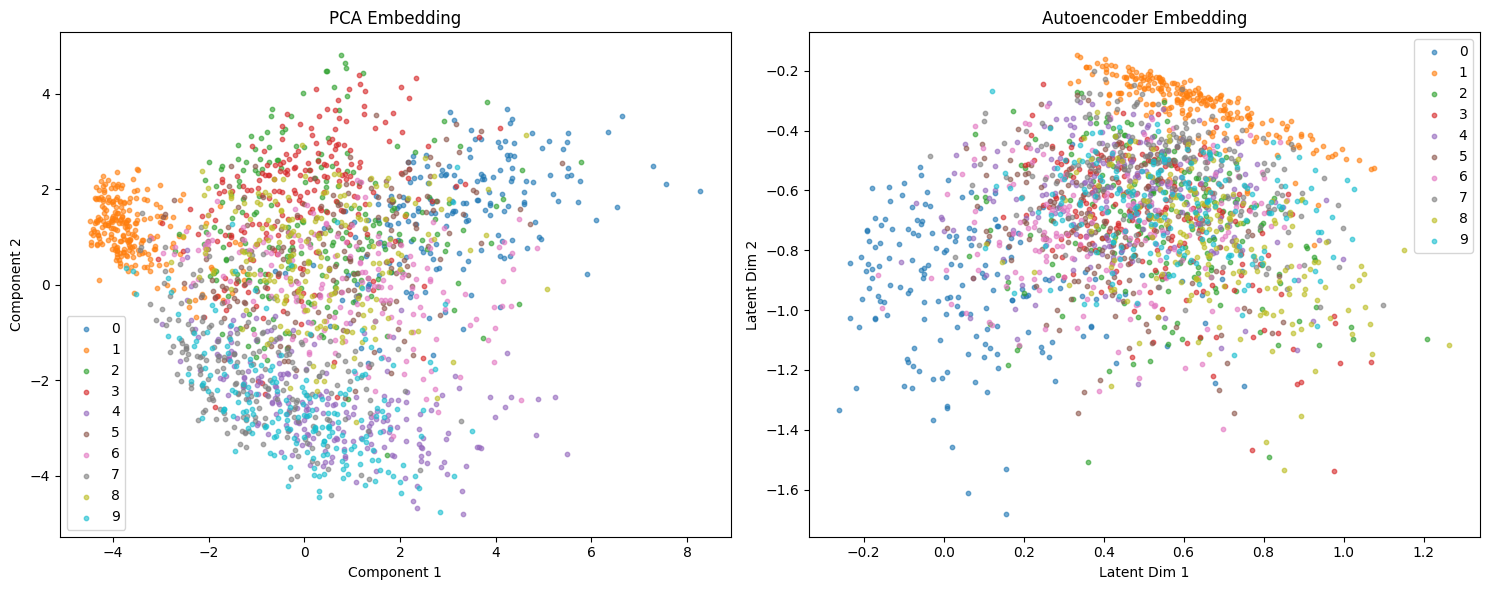

/tmp/ipykernel_35/3918638140.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pca_mse = nn.MSELoss()(torch.tensor(pca_reconstruction), data).item()


PCA Reconstruction MSE: 0.052181
Autoencoder Reconstruction MSE: 0.055345


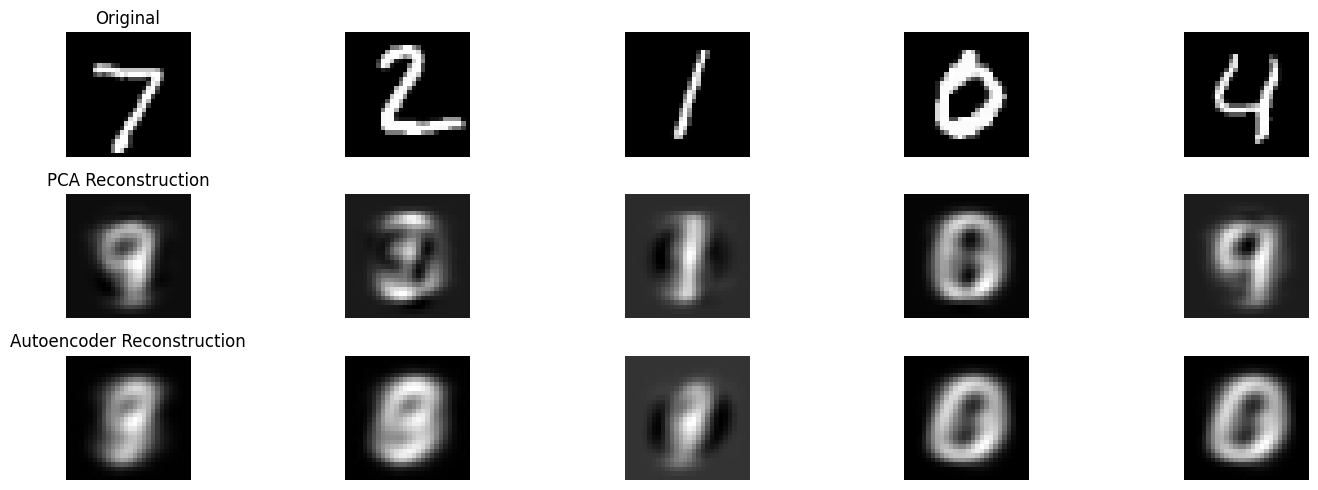


Cosine similarity between autoencoder weights and PCA components:
Dimension 1: 0.2445
Dimension 2: 0.0476


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
latent_size = 2  # 2D latent space for visualization
batch_size = 128
num_epochs = 15
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Linear Autoencoder for PCA-like dimensionality reduction
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        
        # Linear encoder (equivalent to PCA projection)
        self.encoder = nn.Linear(input_size, latent_size, bias=False)
        
        # Linear decoder (equivalent to PCA reconstruction)
        self.decoder = nn.Linear(latent_size, input_size, bias=False)
    
    def forward(self, x):
        x = x.view(-1, input_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Initialize model
model = LinearAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
def train():
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            reconstructed, encoded = model(data)
            
            # Calculate loss
            loss = criterion(reconstructed, data.view(-1, input_size))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Print average loss after each epoch
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Run training
train()

# Comparison with PCA
def compare_with_pca():
    model.eval()
    with torch.no_grad():
        # Get test data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=2000, shuffle=False)
        data, labels = next(iter(test_loader))
        
        # Flatten the data for PCA
        flattened_data = data.view(-1, input_size).numpy()
        
        # Apply PCA
        pca = PCA(n_components=latent_size)
        pca_result = pca.fit_transform(flattened_data)
        
        # Get autoencoder embeddings
        _, autoencoder_result = model(data.to(device))
        autoencoder_result = autoencoder_result.cpu().numpy()
        
        # Plot PCA vs Autoencoder embeddings
        plt.figure(figsize=(15, 6))
        
        # PCA
        plt.subplot(1, 2, 1)
        for i in range(10):
            plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], 
                       label=str(i), alpha=0.6, s=10)
        plt.title('PCA Embedding')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        
        # Autoencoder
        plt.subplot(1, 2, 2)
        for i in range(10):
            plt.scatter(autoencoder_result[labels == i, 0], autoencoder_result[labels == i, 1], 
                       label=str(i), alpha=0.6, s=10)
        plt.title('Autoencoder Embedding')
        plt.xlabel('Latent Dim 1')
        plt.ylabel('Latent Dim 2')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Compare reconstruction quality
        # PCA reconstruction
        pca_reconstruction = pca.inverse_transform(pca_result)
        pca_reconstruction = torch.tensor(pca_reconstruction).view(-1, 1, 28, 28)
        
        # Autoencoder reconstruction
        autoencoder_reconstruction, _ = model(data.to(device))
        autoencoder_reconstruction = autoencoder_reconstruction.cpu().view(-1, 1, 28, 28)
        
        # Calculate MSE
        pca_mse = nn.MSELoss()(torch.tensor(pca_reconstruction), data).item()
        autoencoder_mse = nn.MSELoss()(autoencoder_reconstruction, data).item()
        
        print(f"PCA Reconstruction MSE: {pca_mse:.6f}")
        print(f"Autoencoder Reconstruction MSE: {autoencoder_mse:.6f}")
        
        # Visualize reconstructions
        plt.figure(figsize=(15, 5))
        for i in range(5):
            # Original
            plt.subplot(3, 5, i + 1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            if i == 0:
                plt.title('Original')
            plt.axis('off')
            
            # PCA Reconstruction
            plt.subplot(3, 5, i + 6)
            plt.imshow(pca_reconstruction[i].numpy().reshape(28, 28), cmap='gray')
            if i == 0:
                plt.title('PCA Reconstruction')
            plt.axis('off')
            
            # Autoencoder Reconstruction
            plt.subplot(3, 5, i + 11)
            plt.imshow(autoencoder_reconstruction[i].detach().numpy().reshape(28, 28), cmap='gray')
            if i == 0:
                plt.title('Autoencoder Reconstruction')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Compare the weights of the autoencoder with PCA components
        W_encoder = model.encoder.weight.data.cpu().numpy()
        W_decoder = model.decoder.weight.data.cpu().numpy().T
        pca_components = pca.components_
        
        # Correlation between encoder weights and PCA components
        cosine_similarities = []
        for i in range(latent_size):
            # Compute cosine similarity between encoder weights and PCA components
            # We may need to flip the sign of the components as PCA's direction is arbitrary
            sim1 = np.abs(np.dot(W_encoder[i], pca_components[i]) / 
                   (np.linalg.norm(W_encoder[i]) * np.linalg.norm(pca_components[i])))
            cosine_similarities.append(sim1)
        
        print("\nCosine similarity between autoencoder weights and PCA components:")
        for i, sim in enumerate(cosine_similarities):
            print(f"Dimension {i+1}: {sim:.4f}")

# Run PCA comparison
compare_with_pca()

# Save the model
torch.save(model.state_dict(), 'pca_autoencoder.pth')

## Example 5: Variational Autoencoder (VAE) for Image Generation

Epoch: 1/20 [0/60000 (0%)]	Loss: 549.846985
Epoch: 1/20 [12800/60000 (21%)]	Loss: 187.529022
Epoch: 1/20 [25600/60000 (43%)]	Loss: 161.607300
Epoch: 1/20 [38400/60000 (64%)]	Loss: 150.244873
Epoch: 1/20 [51200/60000 (85%)]	Loss: 138.897491
====> Epoch: 1 Average loss: 173.019844
Epoch: 2/20 [0/60000 (0%)]	Loss: 137.857086
Epoch: 2/20 [12800/60000 (21%)]	Loss: 125.034805
Epoch: 2/20 [25600/60000 (43%)]	Loss: 125.744995
Epoch: 2/20 [38400/60000 (64%)]	Loss: 124.668640
Epoch: 2/20 [51200/60000 (85%)]	Loss: 121.143005
====> Epoch: 2 Average loss: 127.311438
Epoch: 3/20 [0/60000 (0%)]	Loss: 121.193298
Epoch: 3/20 [12800/60000 (21%)]	Loss: 115.769463
Epoch: 3/20 [25600/60000 (43%)]	Loss: 121.260681
Epoch: 3/20 [38400/60000 (64%)]	Loss: 117.030731
Epoch: 3/20 [51200/60000 (85%)]	Loss: 116.336197
====> Epoch: 3 Average loss: 118.440737
Epoch: 4/20 [0/60000 (0%)]	Loss: 115.577728
Epoch: 4/20 [12800/60000 (21%)]	Loss: 113.671707
Epoch: 4/20 [25600/60000 (43%)]	Loss: 111.788605
Epoch: 4/20 [38400

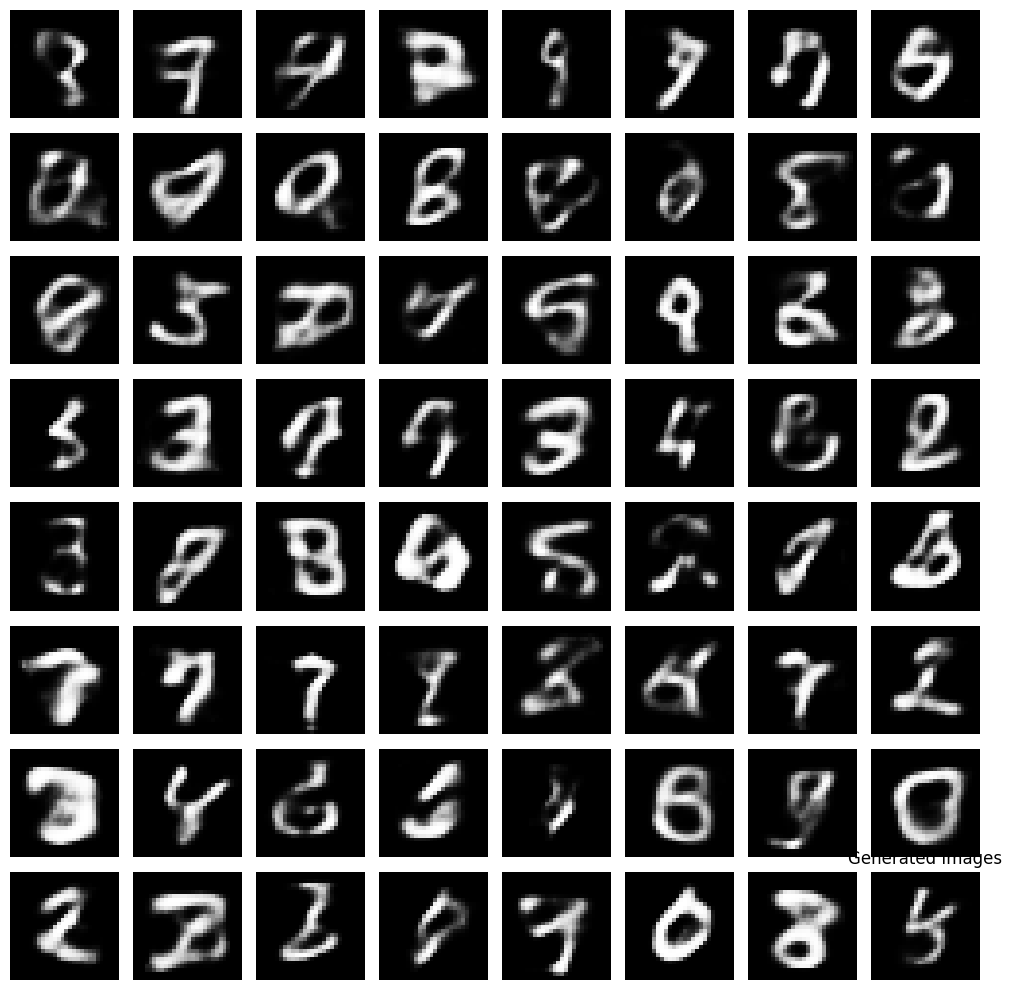

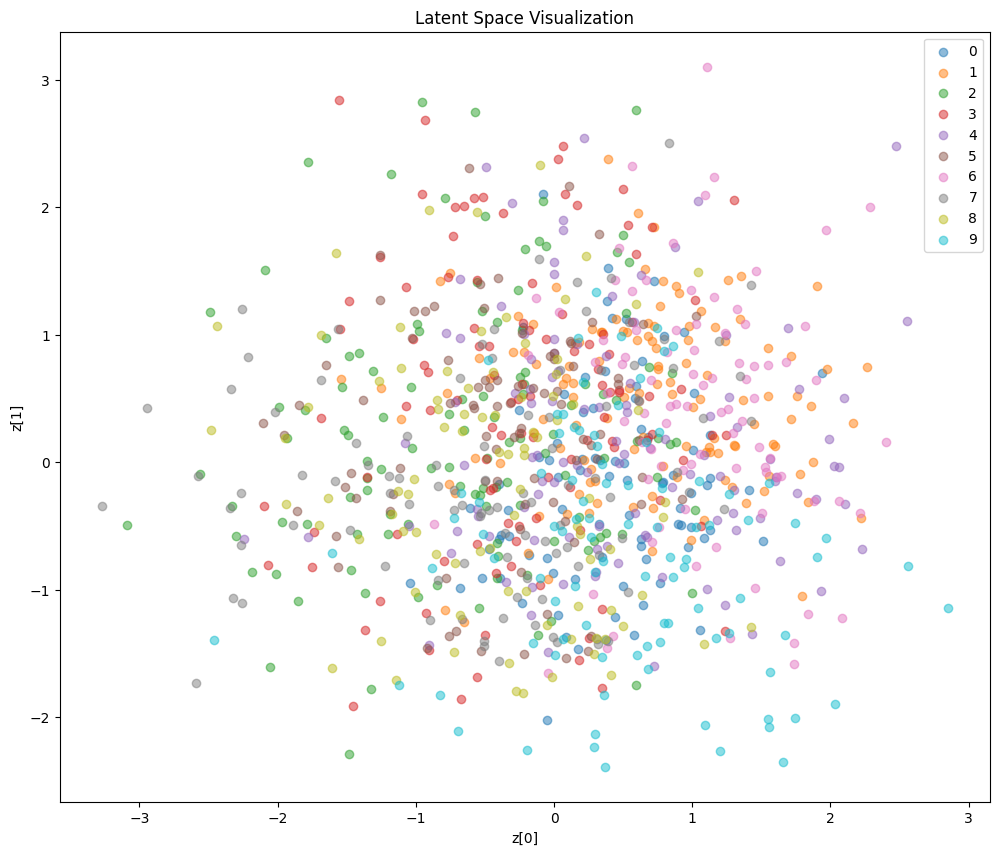

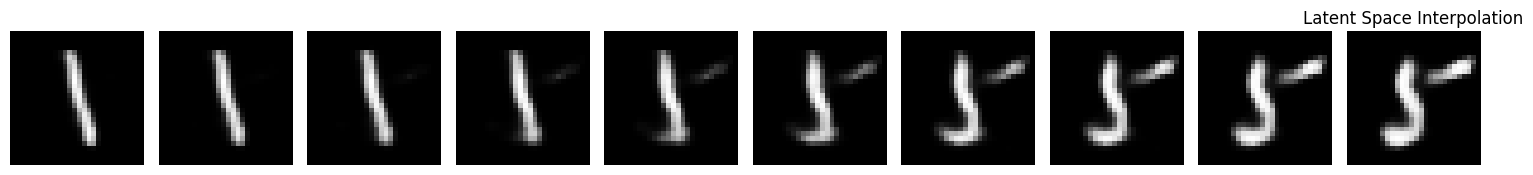

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 256
latent_size = 20
batch_size = 128
num_epochs = 20
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Variational Autoencoder Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder_fc1 = nn.Linear(input_size, hidden_size)
        self.encoder_fc2_mu = nn.Linear(hidden_size, latent_size)
        self.encoder_fc2_logvar = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        self.decoder_fc1 = nn.Linear(latent_size, hidden_size)
        self.decoder_fc2 = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        mu = self.encoder_fc2_mu(h)
        logvar = self.encoder_fc2_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        x_recon = torch.sigmoid(self.decoder_fc2(h))
        return x_recon
    
    def forward(self, x):
        x = x.view(-1, input_size)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Initialize model
model = VAE().to(device)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# VAE loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

# Training
def train():
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
        
        avg_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch+1} Average loss: {avg_loss:.6f}')

# Run training
train()

# Generate images
def generate_images():
    model.eval()
    with torch.no_grad():
        # Sample from latent space
        z = torch.randn(64, latent_size).to(device)
        sample = model.decode(z).cpu()
        
        # Display generated images
        plt.figure(figsize=(10, 10))
        for i in range(64):
            plt.subplot(8, 8, i + 1)
            plt.imshow(sample[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.title('Generated Images')
        plt.show()
        
        # Visualize latent space
        # Get test data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        
        # Encode data
        mu, logvar = model.encode(data.view(-1, input_size))
        z = model.reparameterize(mu, logvar).cpu().numpy()
        
        # Visualize 2D projection of latent space
        plt.figure(figsize=(12, 10))
        for i in range(10):
            plt.scatter(z[labels == i, 0], z[labels == i, 1], label=str(i), alpha=0.5)
        plt.legend()
        plt.title('Latent Space Visualization')
        plt.xlabel('z[0]')
        plt.ylabel('z[1]')
        plt.show()
        
        # Visualize latent space interpolation
        plt.figure(figsize=(15, 5))
        
        # Get two random samples
        idx1, idx2 = np.random.randint(0, len(data), 2)
        
        # Encode the two samples
        z1, _ = model.encode(data[idx1].view(1, -1))
        z2, _ = model.encode(data[idx2].view(1, -1))
        
        # Interpolate between the two latent vectors
        steps = 10
        z_interp = torch.zeros(steps, latent_size).to(device)
        for i in range(steps):
            alpha = i / (steps - 1)
            z_interp[i] = z1 * (1 - alpha) + z2 * alpha
        
        # Decode the interpolated vectors
        interp_samples = model.decode(z_interp)
        
        # Plot interpolation
        for i in range(steps):
            plt.subplot(1, steps, i + 1)
            plt.imshow(interp_samples[i].cpu().reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.title('Latent Space Interpolation')
        plt.show()

# Generate and visualize samples
generate_images()

# Save the model
torch.save(model.state_dict(), 'variational_autoencoder.pth')

## Example 6: Convolutional Autoencoder for Image Compression

100%|██████████| 170M/170M [00:05<00:00, 32.7MB/s] 


Epoch [1/10], Step [100/391], Loss: 0.0423
Epoch [1/10], Step [200/391], Loss: 0.0283
Epoch [1/10], Step [300/391], Loss: 0.0253
Epoch [1/10], Loss: 0.0250, Compression Ratio: 48.00x
Epoch [2/10], Step [100/391], Loss: 0.0208
Epoch [2/10], Step [200/391], Loss: 0.0221
Epoch [2/10], Step [300/391], Loss: 0.0197
Epoch [2/10], Loss: 0.0217, Compression Ratio: 48.00x
Epoch [3/10], Step [100/391], Loss: 0.0206
Epoch [3/10], Step [200/391], Loss: 0.0205
Epoch [3/10], Step [300/391], Loss: 0.0203
Epoch [3/10], Loss: 0.0194, Compression Ratio: 48.00x
Epoch [4/10], Step [100/391], Loss: 0.0209
Epoch [4/10], Step [200/391], Loss: 0.0192
Epoch [4/10], Step [300/391], Loss: 0.0188
Epoch [4/10], Loss: 0.0191, Compression Ratio: 48.00x
Epoch [5/10], Step [100/391], Loss: 0.0176
Epoch [5/10], Step [200/391], Loss: 0.0182
Epoch [5/10], Step [300/391], Loss: 0.0196
Epoch [5/10], Loss: 0.0184, Compression Ratio: 48.00x
Epoch [6/10], Step [100/391], Loss: 0.0199
Epoch [6/10], Step [200/391], Loss: 0.0174

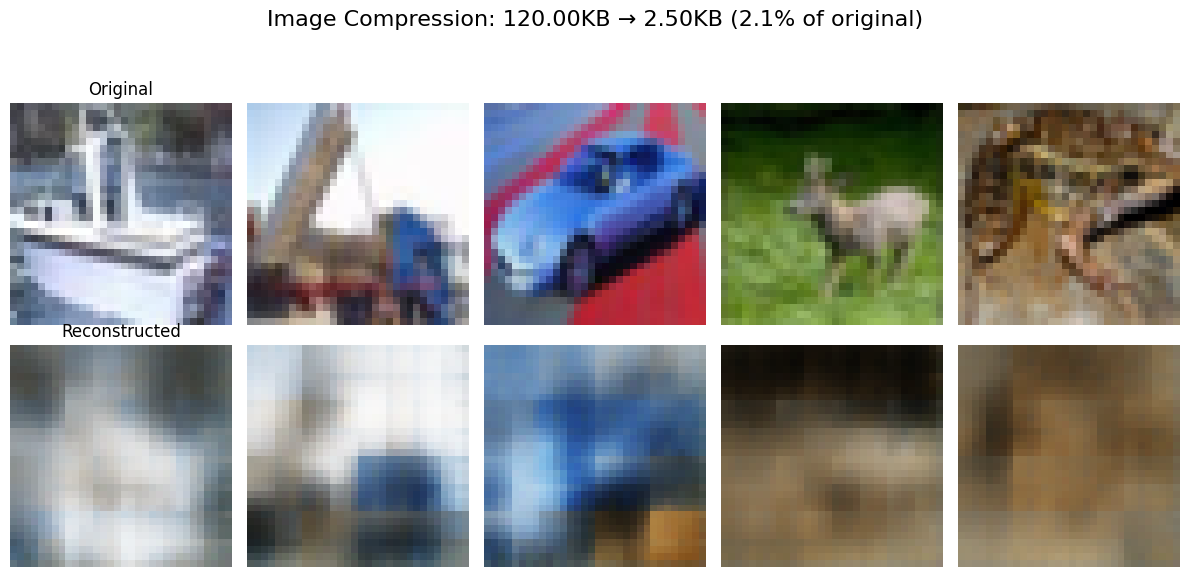

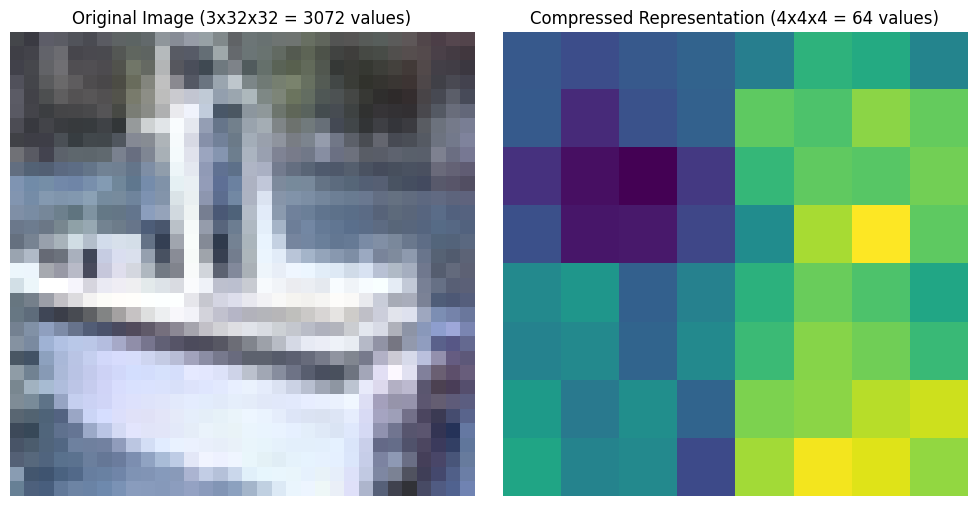

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001
compression_factor = 16  # How much we'll compress the images

# CIFAR-10 Dataset (32x32 color images)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Convolutional Autoencoder Model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 3x32x32
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16x16
            
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8x8
            
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4x4 (64 values - compressed by factor of 48)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Input: 4x4x4
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output: 3x32x32
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Initialize model
model = ConvAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
def train():
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            
            # Forward pass
            outputs, compressed = model(images)
            loss = criterion(outputs, images)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
        
        # Calculate compression statistics
        original_size = images.shape[1] * images.shape[2] * images.shape[3]  # C x H x W
        compressed_size = compressed.shape[1] * compressed.shape[2] * compressed.shape[3]
        compression_ratio = original_size / compressed_size
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Compression Ratio: {compression_ratio:.2f}x')

# Run training
train()

# Visualization function
def visualize_results():
    model.eval()
    with torch.no_grad():
        # Load test images
        test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)
        
        # Get a batch of test images
        images, _ = next(iter(test_loader))
        images = images.to(device)
        
        # Reconstruct images
        reconstructed, compressed = model(images)
        
        # Calculate file sizes for visualization
        original_size_kb = (images.numel() * 32) / 8 / 1024  # 32 bits per float, convert to KB
        compressed_size_kb = (compressed.numel() * 32) / 8 / 1024
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Image Compression: {original_size_kb:.2f}KB → {compressed_size_kb:.2f}KB '
                     f'({compressed_size_kb/original_size_kb*100:.1f}% of original)', fontsize=16)
        
        for i in range(5):
            # Original image
            ax = plt.subplot(2, 5, i+1)
            plt.imshow(images[i].cpu().permute(1, 2, 0))
            plt.axis('off')
            if i == 0:
                ax.set_title('Original')
            
            # Reconstructed image
            ax = plt.subplot(2, 5, i+6)
            plt.imshow(reconstructed[i].cpu().permute(1, 2, 0))
            plt.axis('off')
            if i == 0:
                ax.set_title('Reconstructed')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()
        
        # Visualize compressed representation (first image)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Original Image (3x32x32 = {3*32*32} values)')
        plt.imshow(images[0].cpu().permute(1, 2, 0))
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title(f'Compressed Representation (4x4x4 = {4*4*4} values)')
        # Take first compressed image, reshape for visualization
        comp = compressed[0].cpu()
        # Create a grid visualization of feature maps
        grid_size = int(np.sqrt(comp.shape[0]))
        grid = torch.zeros((grid_size * comp.shape[1], grid_size * comp.shape[2]))
        for j in range(comp.shape[0]):
            row = (j // grid_size) * comp.shape[1]
            col = (j % grid_size) * comp.shape[2]
            grid[row:row+comp.shape[1], col:col+comp.shape[2]] = comp[j]
        plt.imshow(grid, cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Visualize the results
visualize_results()

# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

## Example 7: Sparse Autoencoder for Feature Learning

Epoch [1/15], Batch [100/469], Loss: 0.5278, Recon Loss: 0.5057, Sparsity Loss: 0.0221
Epoch [1/15], Batch [200/469], Loss: 0.4923, Recon Loss: 0.4402, Sparsity Loss: 0.0521
Epoch [1/15], Batch [300/469], Loss: 0.4094, Recon Loss: 0.3901, Sparsity Loss: 0.0192
Epoch [1/15], Batch [400/469], Loss: 0.4111, Recon Loss: 0.3785, Sparsity Loss: 0.0326
Epoch [1/15], Avg Loss: 8.7061, Avg Recon Loss: 0.4343, Avg Sparsity Loss: 8.2718
Epoch [2/15], Batch [100/469], Loss: 0.4136, Recon Loss: 0.3533, Sparsity Loss: 0.0603
Epoch [2/15], Batch [200/469], Loss: 0.3333, Recon Loss: 0.3255, Sparsity Loss: 0.0077
Epoch [2/15], Batch [300/469], Loss: 0.3382, Recon Loss: 0.3140, Sparsity Loss: 0.0243
Epoch [2/15], Batch [400/469], Loss: 0.4045, Recon Loss: 0.3072, Sparsity Loss: 0.0974
Epoch [2/15], Avg Loss: 0.4508, Avg Recon Loss: 0.3258, Avg Sparsity Loss: 0.1249
Epoch [3/15], Batch [100/469], Loss: 0.2996, Recon Loss: 0.2943, Sparsity Loss: 0.0052
Epoch [3/15], Batch [200/469], Loss: 0.2909, Recon Lo

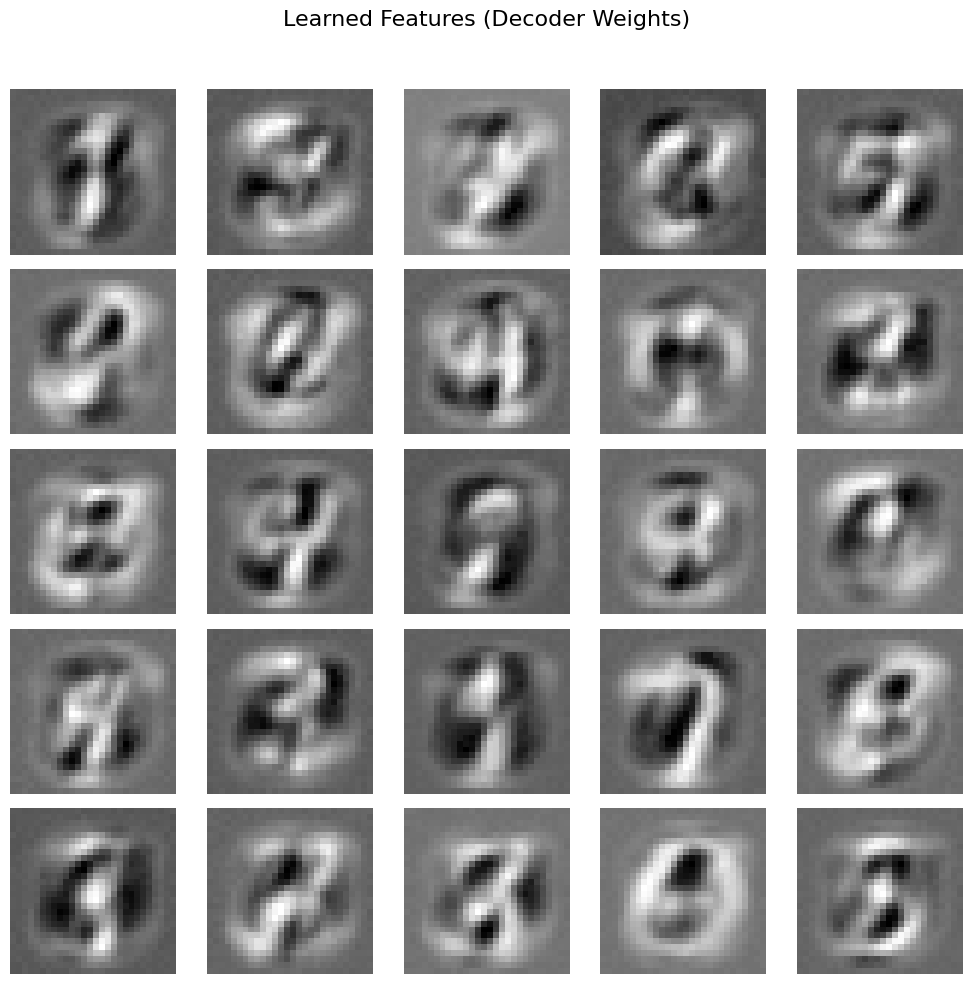

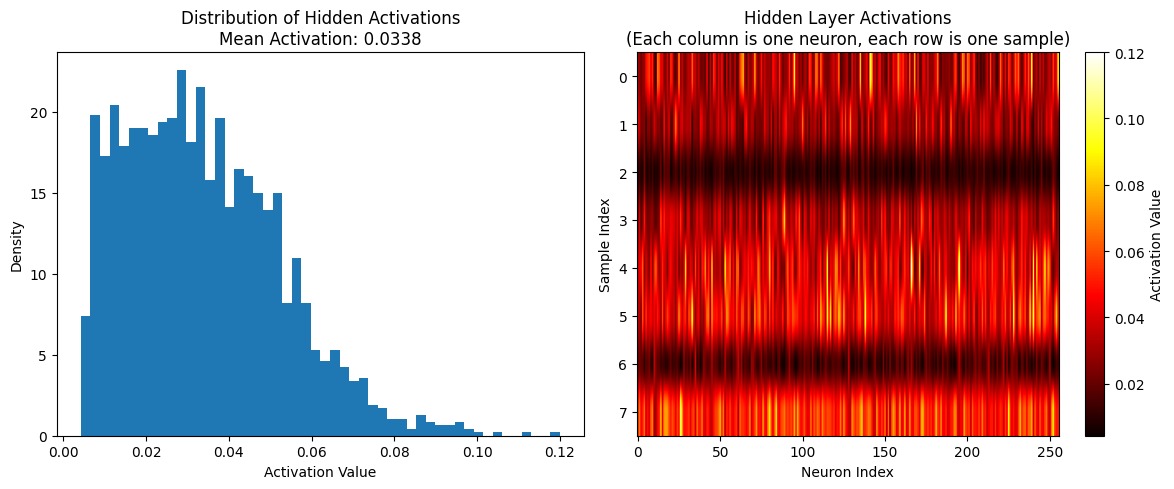

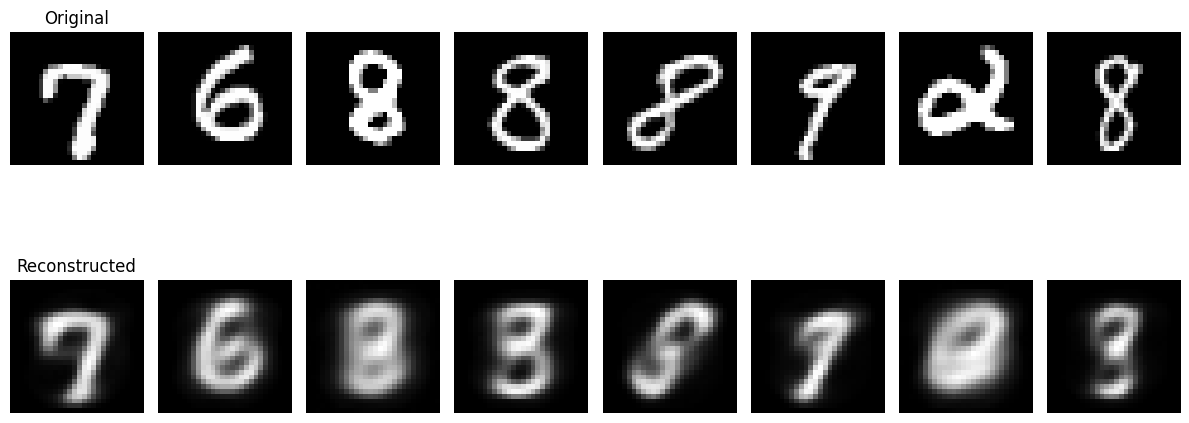

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 256
sparsity_param = 0.05  # Desired sparsity parameter (small value for sparse activations)
beta = 3.0  # Weight of the sparsity penalty term
batch_size = 128
num_epochs = 15
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()  # Sigmoid activation for hidden layer
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def forward(self, x):
        x = x.view(-1, input_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Initialize model
model = SparseAutoencoder().to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for [0,1] range
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# KL Divergence for sparsity penalty
def kl_divergence(rho, rho_hat):
    """
    Compute KL divergence between target sparsity 'rho' and actual sparsity 'rho_hat'
    """
    return rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))

# Training
def train():
    for epoch in range(num_epochs):
        total_loss = 0
        total_sparsity_loss = 0
        total_recon_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            reconstructed, encoded = model(data)
            
            # Calculate average activation of hidden units
            rho_hat = torch.mean(encoded, dim=0)  # Average over batch
            
            # Calculate reconstruction loss
            recon_loss = criterion(reconstructed, data.view(-1, input_size))
            
            # Calculate sparsity loss
            sparsity_loss = beta * torch.sum(kl_divergence(sparsity_param, rho_hat))
            
            # Total loss
            loss = recon_loss + sparsity_loss
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_sparsity_loss += sparsity_loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, '
                      f'Sparsity Loss: {sparsity_loss.item():.4f}')
        
        # Calculate average losses
        avg_loss = total_loss / len(train_loader)
        avg_recon_loss = total_recon_loss / len(train_loader)
        avg_sparsity_loss = total_sparsity_loss / len(train_loader)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, '
              f'Avg Recon Loss: {avg_recon_loss:.4f}, Avg Sparsity Loss: {avg_sparsity_loss:.4f}')

# Run training
train()

# Visualize learned features and reconstructions
def visualize_features_and_reconstructions():
    model.eval()
    with torch.no_grad():
        # Visualize learned features (decoder weights)
        # The weights are of shape [output_size, hidden_size] = [784, 256]
        # We need to transpose them to get [256, 784] so each row represents what a hidden neuron is looking for
        decoder_weights = model.decoder[0].weight.data.cpu().numpy().T  # Transpose to get [256, 784]
        
        # Select random subset of features
        num_features = 25
        feature_indices = np.random.choice(hidden_size, num_features, replace=False)
        
        plt.figure(figsize=(10, 10))
        for i, idx in enumerate(feature_indices):
            plt.subplot(5, 5, i + 1)
            # Now we can reshape to 28x28 since each row has 784 elements
            feature = decoder_weights[idx].reshape(28, 28)
            vmin, vmax = feature.min(), feature.max()
            plt.imshow((feature - vmin) / (vmax - vmin), cmap='gray')
            plt.axis('off')
        
        plt.suptitle('Learned Features (Decoder Weights)', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # Get test data for reconstruction visualization
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        # Get reconstructions
        reconstructed, encoded = model(data)
        
        # Visualize sparsity of hidden activations
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(encoded.cpu().numpy().flatten(), bins=50, density=True)
        plt.title(f'Distribution of Hidden Activations\nMean Activation: {encoded.mean().item():.4f}')
        plt.xlabel('Activation Value')
        plt.ylabel('Density')
        
        # Show heatmap of activations
        plt.subplot(1, 2, 2)
        plt.imshow(encoded.cpu().numpy(), aspect='auto', cmap='hot')
        plt.colorbar(label='Activation Value')
        plt.title('Hidden Layer Activations\n(Each column is one neuron, each row is one sample)')
        plt.xlabel('Neuron Index')
        plt.ylabel('Sample Index')
        plt.tight_layout()
        plt.show()
        
        # Plot original and reconstructed images
        plt.figure(figsize=(12, 6))
        for i in range(8):
            # Original
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].cpu().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            
            # Reconstructed
            plt.subplot(2, 8, i + 9)
            plt.imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        
        plt.tight_layout()
        plt.show()

# Visualize the learned features and reconstructions
visualize_features_and_reconstructions()

# Save the model
torch.save(model.state_dict(), 'sparse_autoencoder.pth')

## Example 8: Sequential Autoencoder for Time Series Forecasting

Epoch [10/100], Loss: 0.0363
Epoch [20/100], Loss: 0.0228
Epoch [30/100], Loss: 0.0024
Epoch [40/100], Loss: 0.0020
Epoch [50/100], Loss: 0.0014
Epoch [60/100], Loss: 0.0019
Epoch [70/100], Loss: 0.0014
Epoch [80/100], Loss: 0.0011
Epoch [90/100], Loss: 0.0012
Epoch [100/100], Loss: 0.0010
Test MSE Loss: 0.0095


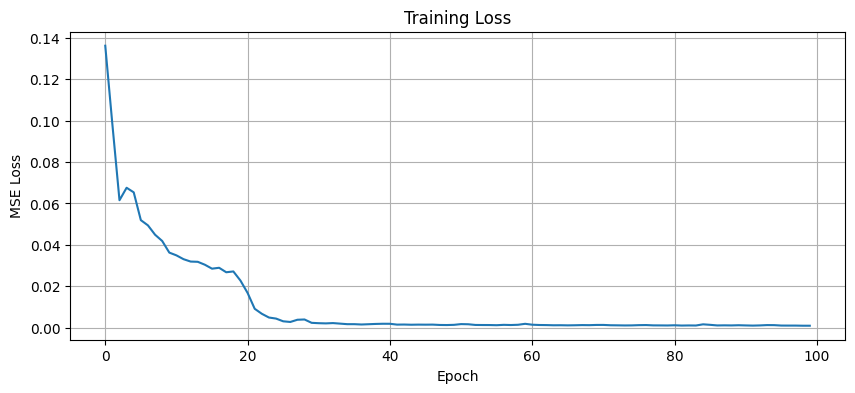

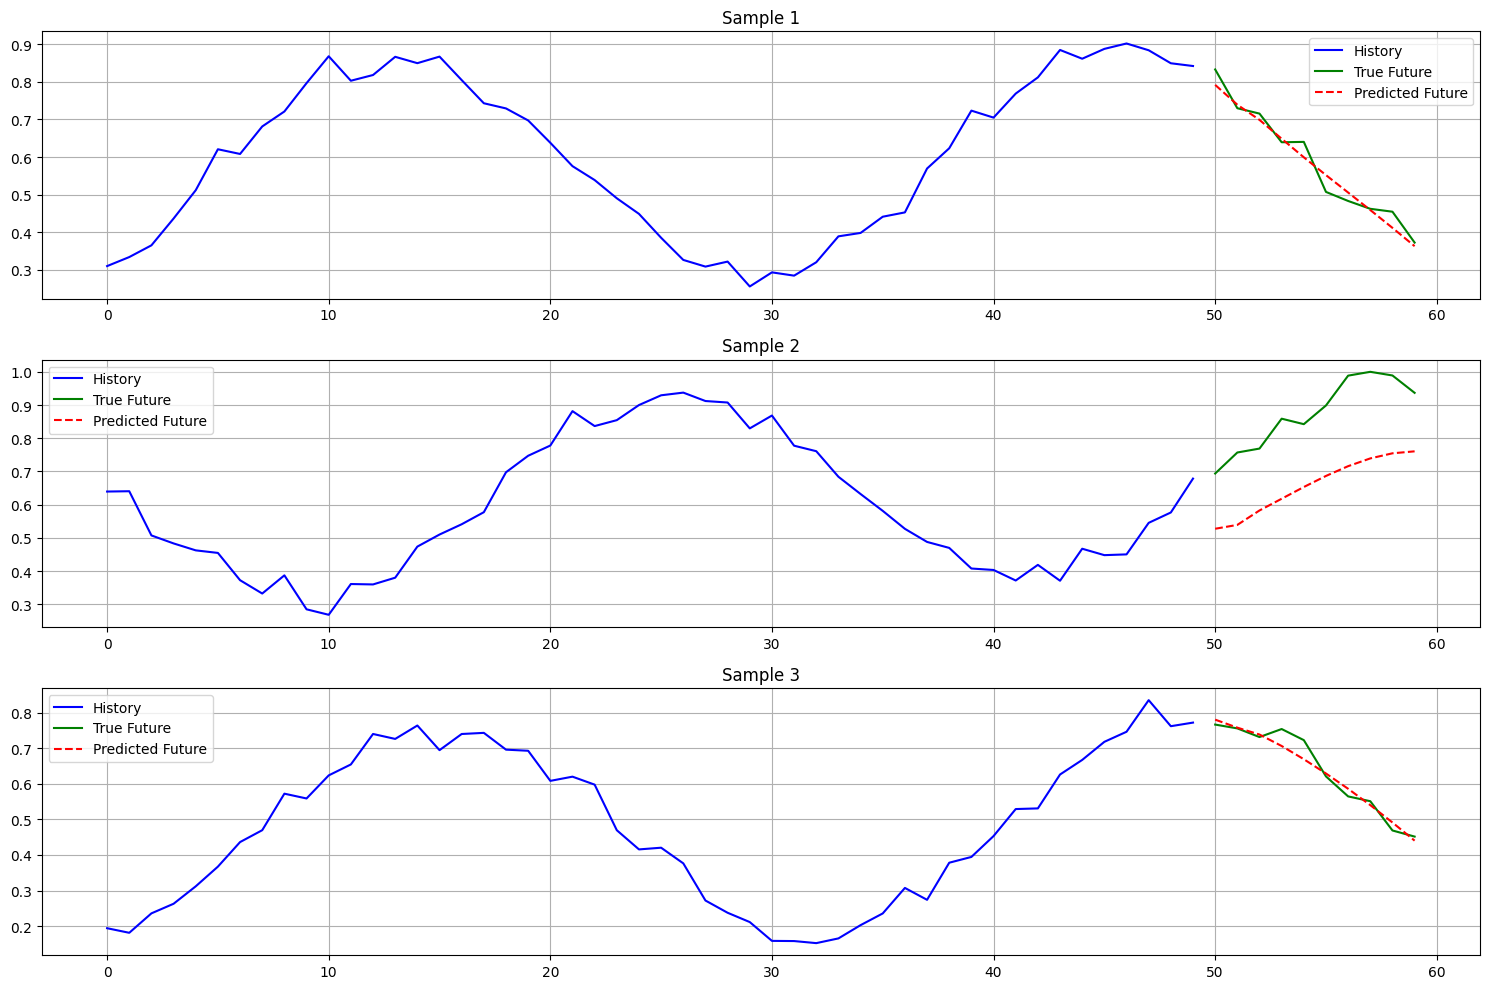

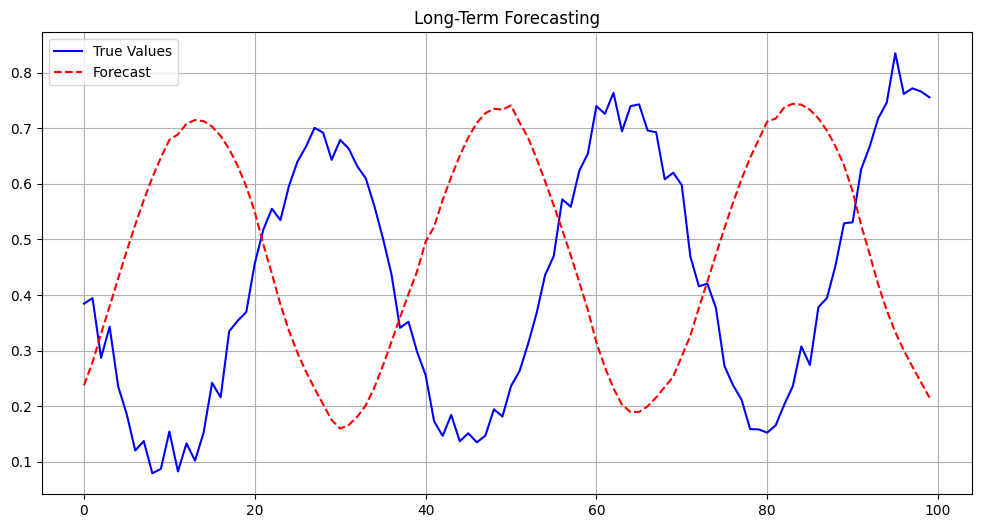

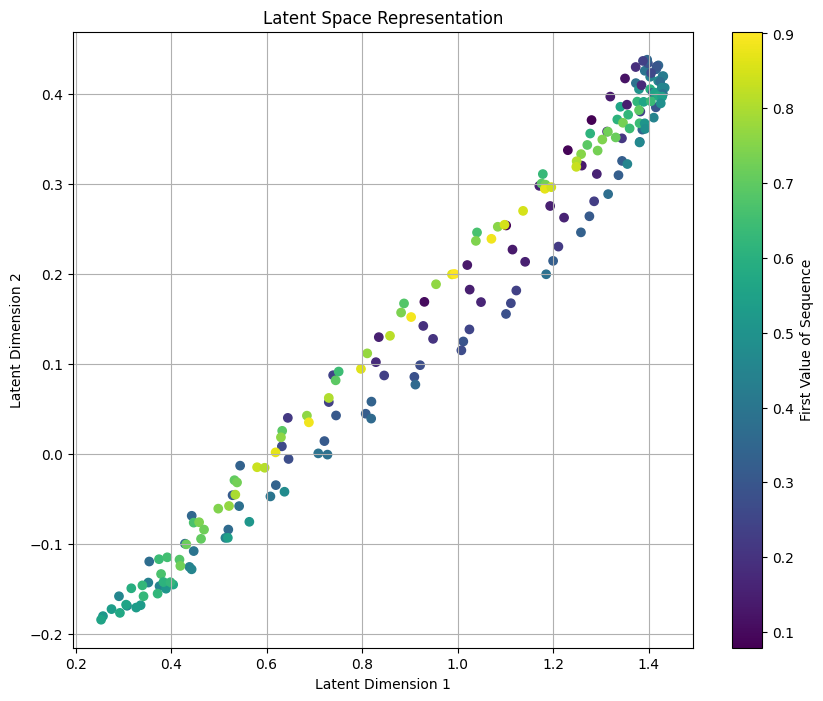

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate synthetic time series data (sine wave + trend + noise)
def generate_time_series(n_samples=1000):
    time = np.arange(n_samples)
    # Sine wave with increasing frequency
    frequency = 0.1 + 0.05 * (time / n_samples)
    series = 10 * np.sin(frequency * time)
    # Add linear trend
    series += 0.05 * time
    # Add noise
    series += np.random.normal(0, 1, n_samples)
    return series

# Parameters
sequence_length = 50  # Length of input sequences
prediction_length = 10  # Number of future steps to predict
hidden_size = 64
latent_size = 16
batch_size = 32
num_epochs = 100
learning_rate = 0.001

# Generate and preprocess data
series = generate_time_series(1000)

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
series = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# Create sequences for training
def create_sequences(data, seq_length, pred_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + pred_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, Y = create_sequences(series, sequence_length, prediction_length)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).unsqueeze(2).to(device)  # [batch, seq_len, 1]
Y_train = torch.FloatTensor(Y_train).unsqueeze(2).to(device)  # [batch, pred_len, 1]
X_test = torch.FloatTensor(X_test).unsqueeze(2).to(device)
Y_test = torch.FloatTensor(Y_test).unsqueeze(2).to(device)

# Create DataLoader
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Sequential Autoencoder for time series forecasting
class SequentialAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, latent_size=16, seq_len=50, pred_len=10):
        super(SequentialAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.latent_size = latent_size
        
        # Encoder (LSTM)
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True
        )
        
        # Latent representation
        self.fc_encoder = nn.Linear(hidden_size, latent_size)
        
        # Decoder starter
        self.fc_decoder = nn.Linear(latent_size, hidden_size)
        
        # Decoder (LSTM)
        self.decoder = nn.LSTM(
            input_size=input_size,  # We'll feed the last value as input
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Encode the sequence
        _, (h_n, c_n) = self.encoder(x)
        
        # Use the last hidden state
        h_last = h_n[-1]  # Shape: [batch_size, hidden_size]
        
        # Project to latent space
        latent = self.fc_encoder(h_last)  # Shape: [batch_size, latent_size]
        
        # Project back to hidden size for decoder
        h_decoder = self.fc_decoder(latent).unsqueeze(0).repeat(2, 1, 1)
        c_decoder = torch.zeros_like(h_decoder).to(device)
        
        # Initialize decoder input with last input value
        decoder_input = x[:, -1:, :]  # Shape: [batch_size, 1, 1]
        
        # Generate future predictions
        outputs = []
        for _ in range(self.pred_len):
            # Pass through decoder LSTM
            decoder_output, (h_decoder, c_decoder) = self.decoder(decoder_input, (h_decoder, c_decoder))
            
            # Project to output space
            prediction = self.output_layer(decoder_output)
            outputs.append(prediction)
            
            # Use this prediction as next input
            decoder_input = prediction
        
        # Concatenate all predictions
        outputs = torch.cat(outputs, dim=1)  # Shape: [batch_size, pred_len, 1]
        
        return outputs, latent

# Initialize model
model = SequentialAutoencoder(
    input_size=1, hidden_size=hidden_size, latent_size=latent_size,
    seq_len=sequence_length, pred_len=prediction_length
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
def train():
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

# Run training
train_losses = train()

# Evaluate and visualize results
def evaluate():
    model.eval()
    with torch.no_grad():
        # Make predictions on test data
        predictions, _ = model(X_test)
        test_loss = criterion(predictions, Y_test).item()
        print(f'Test MSE Loss: {test_loss:.4f}')
        
        # Plot loss curve
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()
        
        # Visualize some predictions
        num_examples = 3
        plt.figure(figsize=(15, 10))
        
        for i in range(num_examples):
            # Get a random test sample
            sample_idx = np.random.randint(0, len(X_test))
            
            input_seq = X_test[sample_idx].cpu().numpy().flatten()
            true_future = Y_test[sample_idx].cpu().numpy().flatten()
            
            # Make prediction
            pred_future, _ = model(X_test[sample_idx].unsqueeze(0))
            pred_future = pred_future.cpu().numpy().flatten()
            
            # Plot
            plt.subplot(num_examples, 1, i+1)
            
            # Plot history
            time_history = np.arange(0, sequence_length)
            plt.plot(time_history, input_seq, 'b-', label='History')
            
            # Plot true future
            time_future = np.arange(sequence_length, sequence_length + prediction_length)
            plt.plot(time_future, true_future, 'g-', label='True Future')
            
            # Plot predicted future
            plt.plot(time_future, pred_future, 'r--', label='Predicted Future')
            
            plt.title(f'Sample {i+1}')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Visualize long-term forecasting
        plt.figure(figsize=(12, 6))
        
        # Start with a test sequence
        current_sequence = X_test[0].unsqueeze(0)
        forecasted_steps = 100
        
        # True values to compare against
        true_indices = train_size + np.arange(forecasted_steps)
        true_values = series[true_indices]
        
        # Forecast iteratively
        forecast = []
        for _ in range(forecasted_steps // prediction_length + 1):
            # Generate prediction
            pred, _ = model(current_sequence)
            pred_np = pred.cpu().numpy().flatten()
            forecast.extend(pred_np[:min(prediction_length, forecasted_steps-len(forecast))])
            
            # Update sequence for next iteration (remove oldest, add predictions)
            last_pred = pred[:, -1:, :]
            current_sequence = torch.cat([current_sequence[:, prediction_length:, :], pred], dim=1)
            
            # Ensure sequence length is maintained
            if current_sequence.shape[1] > sequence_length:
                current_sequence = current_sequence[:, -sequence_length:, :]
        
        # Plot results
        plt.plot(np.arange(forecasted_steps), true_values, 'b-', label='True Values')
        plt.plot(np.arange(forecasted_steps), forecast[:forecasted_steps], 'r--', label='Forecast')
        plt.title('Long-Term Forecasting')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Visualize latent space
        # Generate latent representations for the test data
        _, latent_vectors = model(X_test)
        latent_np = latent_vectors.cpu().numpy()
        
        # Create color mapping based on the first value of each input sequence
        first_values = X_test[:, 0, 0].cpu().numpy()
        
        # Plot first two dimensions of latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_np[:, 0], latent_np[:, 1], c=first_values, cmap='viridis')
        plt.colorbar(scatter, label='First Value of Sequence')
        plt.title('Latent Space Representation')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True)
        plt.show()

# Evaluate and visualize
evaluate()

# Save the model
torch.save(model.state_dict(), 'sequential_autoencoder.pth')

## Example 9: Adversarial Autoencoder for Data Generation

[Epoch 1/30] [Batch 0/469] [D loss: 0.6915] [G loss: 0.6759] [Recon loss: 0.2316]
[Epoch 1/30] [Batch 200/469] [D loss: 0.7631] [G loss: 0.8737] [Recon loss: 0.0660]
[Epoch 1/30] [Batch 400/469] [D loss: 0.6931] [G loss: 0.7384] [Recon loss: 0.0617]
[Epoch 2/30] [Batch 0/469] [D loss: 0.7384] [G loss: 0.8489] [Recon loss: 0.0613]
[Epoch 2/30] [Batch 200/469] [D loss: 0.6579] [G loss: 0.6955] [Recon loss: 0.0609]
[Epoch 2/30] [Batch 400/469] [D loss: 0.6940] [G loss: 0.8084] [Recon loss: 0.0599]
[Epoch 3/30] [Batch 0/469] [D loss: 0.7133] [G loss: 0.6525] [Recon loss: 0.0604]
[Epoch 3/30] [Batch 200/469] [D loss: 0.6888] [G loss: 0.6466] [Recon loss: 0.0616]
[Epoch 3/30] [Batch 400/469] [D loss: 0.6898] [G loss: 0.7620] [Recon loss: 0.0646]
[Epoch 4/30] [Batch 0/469] [D loss: 0.6730] [G loss: 0.6983] [Recon loss: 0.0629]
[Epoch 4/30] [Batch 200/469] [D loss: 0.6754] [G loss: 0.7243] [Recon loss: 0.0594]
[Epoch 4/30] [Batch 400/469] [D loss: 0.6834] [G loss: 0.7130] [Recon loss: 0.0588]


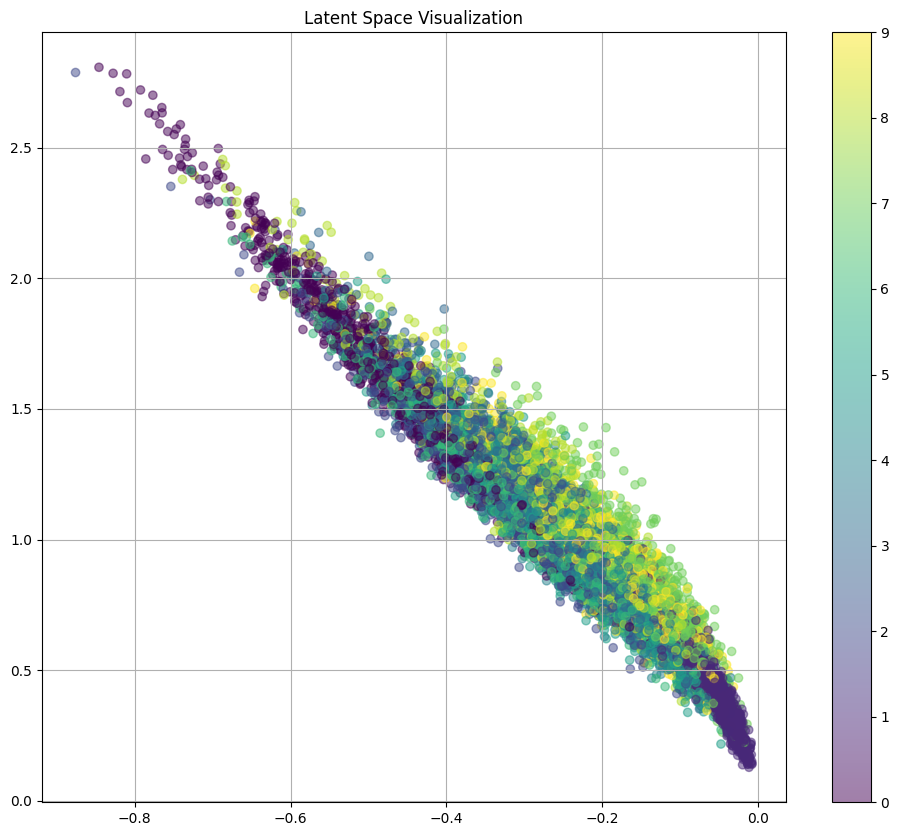

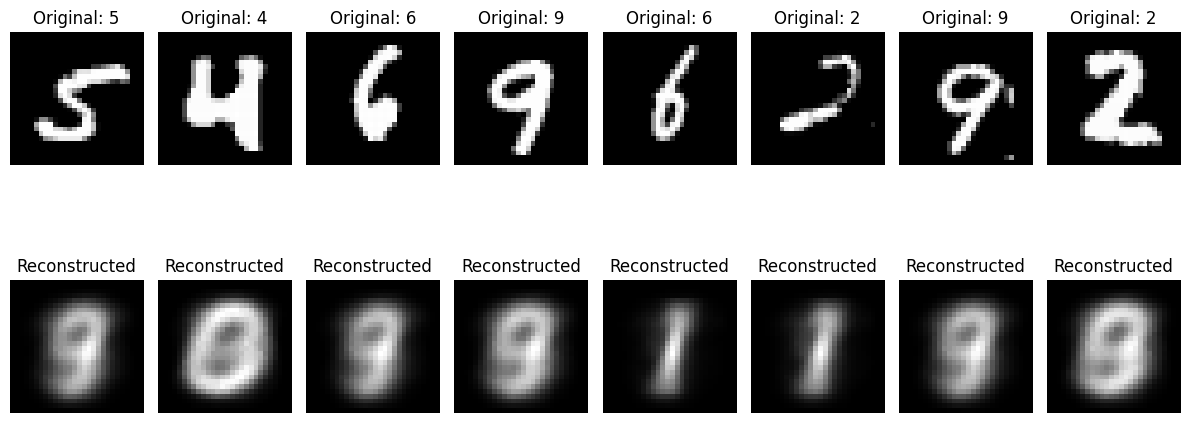

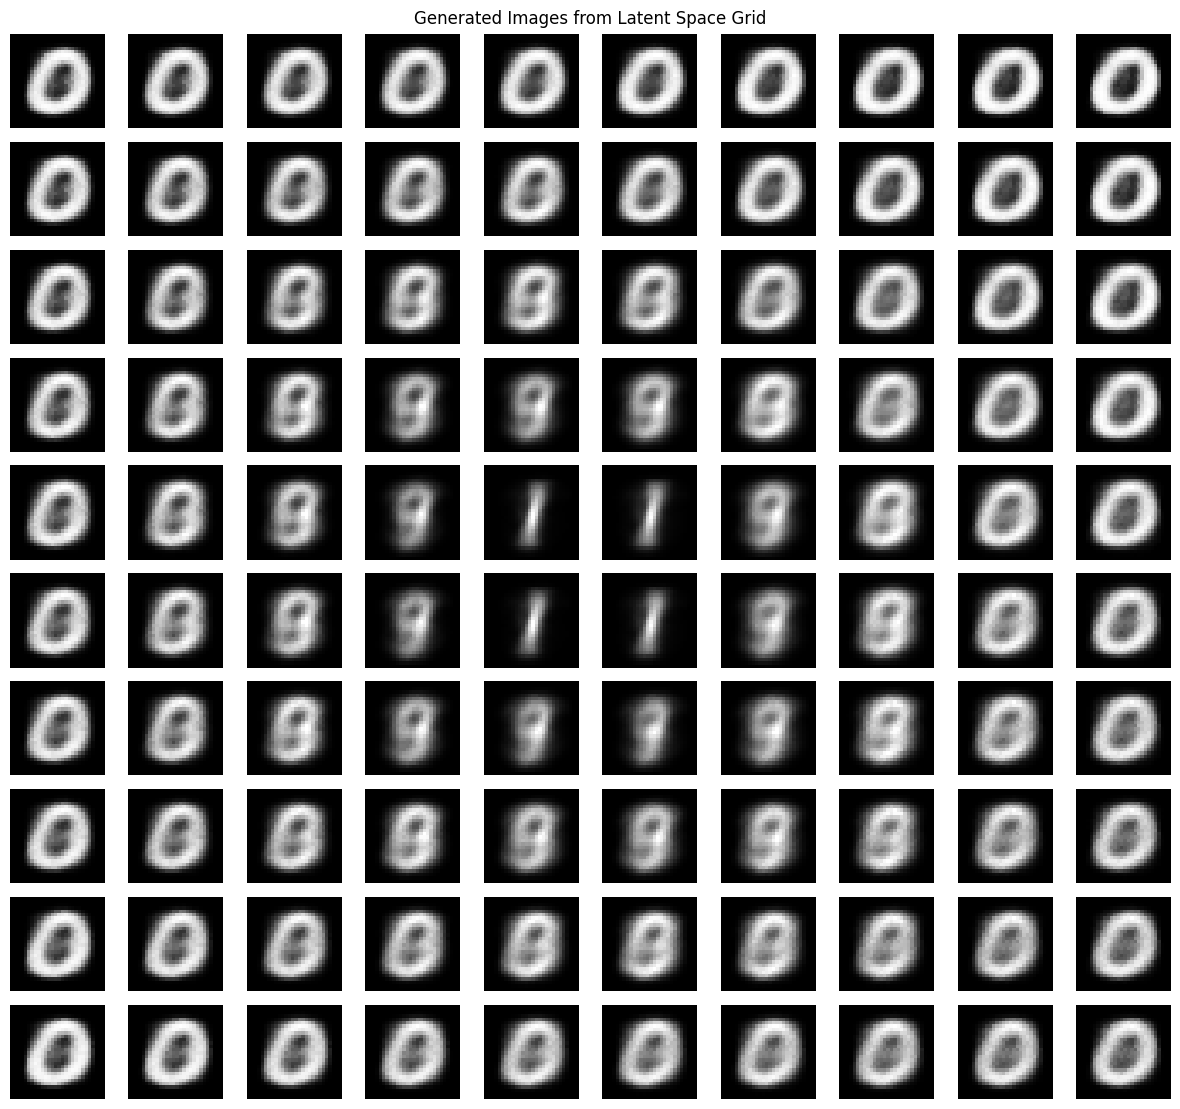

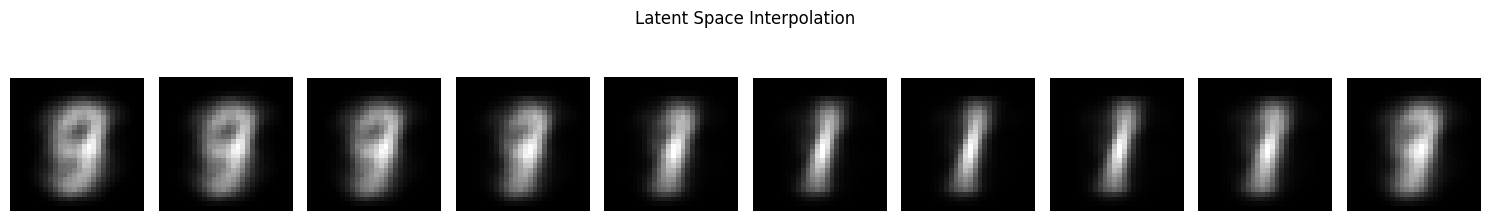

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 256
latent_size = 2  # Small latent space for visualization
batch_size = 128
num_epochs = 30
learning_rate = 0.0002
beta1 = 0.5  # Adam optimizer parameter

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Adversarial Autoencoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )
    
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.model(x)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x_recon = self.model(z)
        return x_recon

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        validity = self.model(z)
        return validity

# Initialize networks
encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_AE = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Loss functions
reconstruction_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()

# Training
def train():
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(train_loader):
            # Configure input
            real_imgs = imgs.to(device)
            
            # Create labels
            valid = torch.ones((imgs.size(0), 1)).to(device)
            fake = torch.zeros((imgs.size(0), 1)).to(device)
            
            # -----------------
            #  Train Autoencoder
            # -----------------
            optimizer_AE.zero_grad()
            
            # Generate latent representation
            z = encoder(real_imgs)
            
            # Reconstruct image
            reconstructed = decoder(z)
            
            # Compute reconstruction loss
            recon_loss = reconstruction_loss(reconstructed, real_imgs.view(-1, input_size))
            
            # Compute generator loss (fool the discriminator)
            validity = discriminator(z)
            g_loss = adversarial_loss(validity, valid)
            
            # Total autoencoder loss
            ae_loss = recon_loss + g_loss
            
            ae_loss.backward()
            optimizer_AE.step()
            
            # -----------------
            #  Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            
            # Sample from normal distribution
            z_prior = torch.randn(imgs.size(0), latent_size).to(device)
            
            # Compute discriminator loss
            real_loss = adversarial_loss(discriminator(z_prior), valid)
            fake_loss = adversarial_loss(discriminator(encoder(real_imgs).detach()), fake)
            d_loss = 0.5 * (real_loss + fake_loss)
            
            d_loss.backward()
            optimizer_D.step()
            
            # Print progress
            if i % 200 == 0:
                print(
                    f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] [Recon loss: {recon_loss.item():.4f}]"
                )

# Run training
train()

# Visualization functions
def visualize_latent_space():
    encoder.eval()
    with torch.no_grad():
        # Get test data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)
        
        all_z = []
        all_labels = []
        
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            z = encoder(imgs)
            all_z.append(z.cpu().numpy())
            all_labels.append(labels.numpy())
        
        all_z = np.concatenate(all_z, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        
        # Plot latent space
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
        plt.colorbar(scatter)
        plt.title('Latent Space Visualization')
        plt.grid(True)
        plt.show()

def visualize_reconstructions():
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Get some test data
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)
        
        imgs, labels = next(iter(test_loader))
        imgs = imgs.to(device)
        
        # Get reconstructions
        z = encoder(imgs)
        reconstructed = decoder(z)
        
        # Plot original and reconstructed images
        plt.figure(figsize=(12, 6))
        for i in range(8):
            # Original image
            plt.subplot(2, 8, i+1)
            plt.imshow(imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title(f"Original: {labels[i]}")
            plt.axis('off')
            
            # Reconstructed image
            plt.subplot(2, 8, i+9)
            plt.imshow(reconstructed[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

def generate_from_latent():
    decoder.eval()
    with torch.no_grad():
        # Create grid of latent points
        x = np.linspace(-3, 3, 10)
        y = np.linspace(-3, 3, 10)
        
        z_grid = np.array([(i, j) for i in x for j in y])
        z_grid_tensor = torch.FloatTensor(z_grid).to(device)
        
        # Generate images from grid
        generated = decoder(z_grid_tensor)
        
        # Plot generated images
        plt.figure(figsize=(12, 12))
        for i in range(len(z_grid)):
            plt.subplot(10, 10, i+1)
            plt.imshow(generated[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle('Generated Images from Latent Space Grid', y=0.92)
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # Create smooth transitions between two random points
        z1 = torch.randn(1, latent_size).to(device)
        z2 = torch.randn(1, latent_size).to(device)
        
        steps = 10
        interpolated_z = torch.zeros(steps, latent_size).to(device)
        
        for i in range(steps):
            alpha = i / (steps - 1)
            interpolated_z[i] = z1 * (1 - alpha) + z2 * alpha
        
        # Generate images from interpolated points
        interpolated_imgs = decoder(interpolated_z)
        
        # Plot interpolation
        plt.figure(figsize=(15, 3))
        for i in range(steps):
            plt.subplot(1, steps, i+1)
            plt.imshow(interpolated_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle('Latent Space Interpolation', y=0.95)
        plt.show()

# Visualize results
visualize_latent_space()
visualize_reconstructions()
generate_from_latent()

# Save models
torch.save(encoder.state_dict(), 'aae_encoder.pth')
torch.save(decoder.state_dict(), 'aae_decoder.pth')
torch.save(discriminator.state_dict(), 'aae_discriminator.pth')